In [3]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

1
0
GeForce GTX 1060


In [4]:
from torchvision import datasets, transforms
import helper

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.FashionMNIST('/F_MNIST_data', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

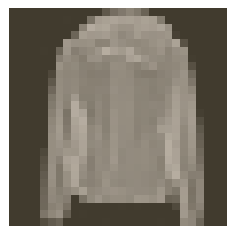

In [5]:
image, label = next(iter(trainloader))
helper.imshow(image[0, :])

In [6]:
from torch import nn, optim
import torch.nn.functional as F

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.out(x), dim = 1)
        
        return x

In [6]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [7]:
epochs = 10

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        logps = model.forward(images)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f'Training loss: {running_loss}')

Training loss: 479.54413256049156
Training loss: 367.84268605709076
Training loss: 336.12018272280693
Training loss: 312.98709404468536
Training loss: 295.30069284141064
Training loss: 284.37563037127256
Training loss: 272.2389514371753
Training loss: 266.5160133391619
Training loss: 254.98064855486155
Training loss: 249.66892566531897


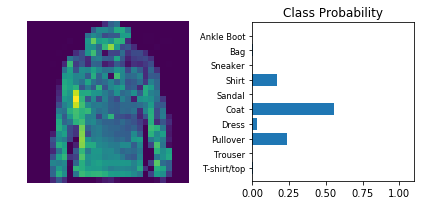

In [9]:
testset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model.forward(img))

helper.view_classify(img, ps, version = 'Fashion')

# Validation

In [15]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0
    for images, labels in  trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print('Epoch: {}/{}'.format(e+1, epochs),
              'Training Loss: {:.3f}..'.format(train_loss/len(trainloader)),
              'Test Loss: {:.3f}..'.format(test_loss/len(testloader)),
              'Test Accuracy: {:.3f}..'.format(accuracy/len(testloader)))
        

Epoch: 1/30 Training Loss: 0.512.. Test Loss: 0.453.. Test Accuracy: 0.839..
Epoch: 2/30 Training Loss: 0.393.. Test Loss: 0.394.. Test Accuracy: 0.861..
Epoch: 3/30 Training Loss: 0.357.. Test Loss: 0.406.. Test Accuracy: 0.851..
Epoch: 4/30 Training Loss: 0.335.. Test Loss: 0.381.. Test Accuracy: 0.856..
Epoch: 5/30 Training Loss: 0.318.. Test Loss: 0.366.. Test Accuracy: 0.870..
Epoch: 6/30 Training Loss: 0.305.. Test Loss: 0.370.. Test Accuracy: 0.868..
Epoch: 7/30 Training Loss: 0.295.. Test Loss: 0.366.. Test Accuracy: 0.871..
Epoch: 8/30 Training Loss: 0.287.. Test Loss: 0.362.. Test Accuracy: 0.872..
Epoch: 9/30 Training Loss: 0.275.. Test Loss: 0.371.. Test Accuracy: 0.875..
Epoch: 10/30 Training Loss: 0.268.. Test Loss: 0.381.. Test Accuracy: 0.868..
Epoch: 11/30 Training Loss: 0.259.. Test Loss: 0.363.. Test Accuracy: 0.873..
Epoch: 12/30 Training Loss: 0.256.. Test Loss: 0.344.. Test Accuracy: 0.883..
Epoch: 13/30 Training Loss: 0.246.. Test Loss: 0.367.. Test Accuracy: 0.8

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

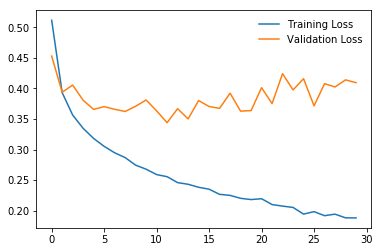

In [19]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(frameon = False)

# DROPOUT

In [36]:
class ClassifierWD(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.dropout(F.relu(self.fc1(x)), p = 0.2)
        x = F.dropout(F.relu(self.fc2(x)), p = 0.2)
        x = F.dropout(F.relu(self.fc3(x)), p = 0.2)
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

In [37]:
model = ClassifierWD()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels).item()
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print('Epoch: {}/{}'.format(e+1, epochs),
              'Training Loss: {:.3f}..'.format(train_loss/len(trainloader)),
              'Test Loss: {:.3f}..'.format(test_loss/len(testloader)),
              'Test Accuracy: {:.3f}..'.format(accuracy/len(testloader)))

Epoch: 1/30 Training Loss: 0.510.. Test Loss: 0.453.. Test Accuracy: 0.834..
Epoch: 2/30 Training Loss: 0.386.. Test Loss: 0.462.. Test Accuracy: 0.835..
Epoch: 3/30 Training Loss: 0.351.. Test Loss: 0.378.. Test Accuracy: 0.865..
Epoch: 4/30 Training Loss: 0.334.. Test Loss: 0.378.. Test Accuracy: 0.865..
Epoch: 5/30 Training Loss: 0.317.. Test Loss: 0.375.. Test Accuracy: 0.870..
Epoch: 6/30 Training Loss: 0.303.. Test Loss: 0.395.. Test Accuracy: 0.862..
Epoch: 7/30 Training Loss: 0.292.. Test Loss: 0.391.. Test Accuracy: 0.869..
Epoch: 8/30 Training Loss: 0.278.. Test Loss: 0.360.. Test Accuracy: 0.878..
Epoch: 9/30 Training Loss: 0.273.. Test Loss: 0.380.. Test Accuracy: 0.870..
Epoch: 10/30 Training Loss: 0.266.. Test Loss: 0.371.. Test Accuracy: 0.880..
Epoch: 11/30 Training Loss: 0.258.. Test Loss: 0.361.. Test Accuracy: 0.876..
Epoch: 12/30 Training Loss: 0.252.. Test Loss: 0.362.. Test Accuracy: 0.879..
Epoch: 13/30 Training Loss: 0.247.. Test Loss: 0.377.. Test Accuracy: 0.8

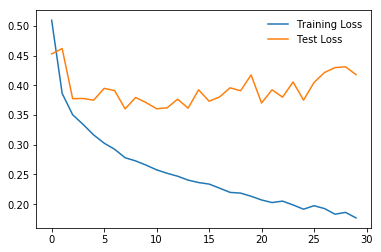

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend(frameon = False)